In [1]:
import openai
import os
from time import time, sleep
import pandas as pd
import numpy as np
import textwrap
import re

openai.api_key = os.getenv("OPENAI_PRIVATE_KEY")

def chunk_text(text, chunk_size, overlap_size):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end - overlap_size
    return chunks

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [2]:
# load the data
df = pd.read_csv("partijprogrammas/partijprogrammas.csv")

In [3]:
# if data is already embedded, load it
df = pd.read_csv('embeddings/embedded_partijprogrammas.csv')
df['embedding'] = df.embedding.apply(eval).apply(np.array)

In [ ]:
# if data is not embedded, embed it 
# this takes a while (a minute), and costs money, so save the result
df['embedding'] = df.tekst.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
df.to_csv('embedded_partijprogrammas.csv', index=False)

In [4]:
# create a matrix of the embeddings
matrix = np.vstack(df.embedding.values)
matrix.shape

(122, 1536)

In [5]:
from sklearn.cluster import KMeans

# find the optimal number of clusters 
n_clusters = 19

# create a kmeans object 
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_


/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


" for i, txt in enumerate(df['partij']):\n    plt.annotate(txt, (x[i], y[i]))\n "

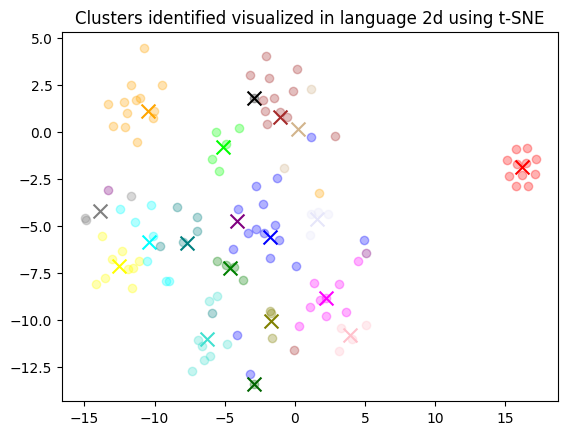

In [17]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

# visualize the clusters in 2d using t-SNE
tsne = TSNE(n_components=2, perplexity=19, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

colors = ["purple", "red", "green", "blue", "orange", "yellow", "black", "brown", "pink", "gray", "olive", "cyan", "magenta", "lime", "teal", "lavender", "turquoise", "darkgreen", "tan"]
party_name_list = df.partij.unique() 

for category, color in enumerate(colors):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)
    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")

""" for i, txt in enumerate(df['partij']):
    plt.annotate(txt, (x[i], y[i]))
 """

In [8]:
from openai.embeddings_utils import get_embedding, cosine_similarity

# search through the partijprogrammas for a specific standpunt
def search_partijprogrammas(df, description, n=3, pprint=True):
    embedding = get_embedding(
        description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding.apply(lambda x: cosine_similarity(x, embedding))

    results = df.sort_values("similarity", ascending=False).head(n)
    
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [12]:
results = search_partijprogrammas(df, "boeren moeten worden opgekocht", n=5)

id

partij

verkiezing

locatie

thema

tekst

token_estimate

tokens

embedding

Cluster

similarity

